<a href="https://colab.research.google.com/github/Nuamaan/NetFlix-Recommender/blob/main/NetFlix_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
aa=pd.read_csv('/content/drive/MyDrive/ECS271/NetFlix Assignment/train(2).csv')
aa=aa[['movie-id','customer-id','rating']]

In [ ]:
#movie-id to mov# mapping
j=0
mov_map={}
for i in aa['movie-id'].unique():
  mov_map[i]=j 
  j+=1

In [ ]:
#customer-id to cus# mapping
j=0
cus_map={}
for i in aa['customer-id'].unique():
  cus_map[i]=j 
  j+=1

In [ ]:
aa.head(5)

In [ ]:
aa['customer-id'].value_counts()

16272    4738
3321     3547
1333     2396
11043    2305
21823    2263
         ... 
29907       1
20482       1
18014       1
17800       1
15617       1
Name: customer-id, Length: 5905, dtype: int64

In [ ]:
users_gt_10=aa['customer-id'].value_counts().reset_index(name="count").query("count > 3")
users_lt_10=aa['customer-id'].value_counts().reset_index(name="count").query("count <= 3")

In [ ]:
user_ids_gt_10=users_gt_10['index'].to_list()
len(user_ids_gt_10)

5822

Dont Choose customers having done less than or equal to 10 reviews.

In [ ]:
dont_choose_from_df=aa[~aa['customer-id'].isin(user_ids_gt_10)]

**Customer- Movie data not to be included in the validation set**

In [ ]:
users_ids_train=dont_choose_from_df['customer-id'].to_list()
movies_ids_train=dont_choose_from_df['movie-id'].to_list()
users_train=[cus_map[i] for i in users_ids_train]
movies_train=[mov_map[i] for i in movies_ids_train]


In [ ]:
X_train_d=list(zip(users_train , movies_train))
Y_train_d=dont_choose_from_df['rating'].to_list()

In [ ]:
len(Y_train_d)

173

**Customer- Movie data to be used for randomly choosing the validation set**

In [ ]:
choose_from_df=aa.loc[aa['customer-id'].isin(user_ids_gt_10)]

In [ ]:
users_ids=choose_from_df['customer-id'].to_list()
movies_ids=choose_from_df['movie-id'].to_list()
users=[cus_map[i] for i in users_ids]
movies=[mov_map[i] for i in movies_ids]


In [ ]:
X_choose=list(zip(users , movies))
Y_choose=choose_from_df['rating'].to_list()

In [ ]:
X_choose[0]

(0, 0)

**TRAINING PIPELINE**

In [ ]:
from sklearn.utils.extmath import randomized_svd

In [ ]:
# P=np.loadtxt('/content/drive/MyDrive/ECS271/NetFlix Assignment/P_50.out')
# Q=np.loadtxt('/content/drive/MyDrive/ECS271/NetFlix Assignment/Q_50.out')
# matrix=np.loadtxt('/content/drive/MyDrive/ECS271/NetFlix Assignment/matrix.out')

Loss Function for Matrix Completion

In [ ]:
def loss(P,Q,lamb,checkpoints,M_curr,mm,total_mean,bias_cus,bias_movie,len_train):
    
    n=0
    pred=bias_cus + bias_movie + M_curr + total_mean
    zz=torch.zeros_like(mm)
    

    SS=torch.where(mm>0,(mm-pred)**2,zz)
    sum=torch.sum(SS)
    l_1=torch.norm(P, dim=1)
    l_2=torch.norm(Q, dim=0)
    l_b_c=torch.norm(bias_cus)
    l_b_m=torch.norm(bias_movie)
    loss_compl=lamb*(torch.sum(l_1) + torch.sum(l_2) + l_b_c + l_b_m)

    return (sum+loss_compl)/len_train   

In [ ]:
def val_loss(M_curr,total_mean,bias_cus,bias_movie,X_test,Y_test):
    with torch.no_grad():
      sum=0
      n=0
      pred=total_mean + bias_cus + bias_movie + M_curr
      for i in range(len(X_test)):
        n+=1
        u,m=X_test[i][0],X_test[i][1]
        sum+=(Y_test[i]-pred[u][m])**2 

    

    return (sum)/n   

In [ ]:
def optimize(p,q,mm,lamb,num_epochs,len_train):
  
  checkpoints={}
  for i in range(mm.shape[0]):
      points=np.where(mm[i]!=0)
      checkpoints[i]=points[0] 
  ss=0
  n=0
  for i in checkpoints.keys():
      for j in checkpoints[i]:
        n+=1
        ss+=mm[i][j] 
  total_mean=ss/n      


  P = torch.from_numpy(p)
  Q = torch.from_numpy(q)
  P.requires_grad=True
  Q.requires_grad=True
  b_c=np.mean(mm,axis=1,keepdims=True) 
  b_m=np.mean(mm,axis=0,keepdims=True) 
  bias_cus=torch.from_numpy(b_c)
  bias_movie=torch.from_numpy(b_m)
  bias_cus.requires_grad=True
  bias_movie.requires_grad=True
  matrix = torch.from_numpy(mm)  
  optimizer=torch.optim.SGD([P,Q,bias_cus,bias_movie],lr=learning_rate)
  l_hist=[]
  val_hist=[]
  for i in range(num_epochs):
    
    M_curr=torch.matmul(P, Q)

    ll=loss(P,Q,lamb,checkpoints,M_curr,matrix,total_mean,bias_cus,bias_movie,len_train)

    ll.backward()

    optimizer.step()

    optimizer.zero_grad()

    v_loss=val_loss(M_curr,total_mean,bias_cus,bias_movie,X_test,Y_test)
    l_hist.append(ll.item())
    val_hist.append(v_loss)
    print(f'Lambda: {lamb} ,Epoch: {i}, loss={ll.item()}, val_loss={v_loss}')
    
    if i in [4500,5000,5500]:
      with torch.no_grad():
        pred=M_curr+bias_cus+bias_movie+total_mean
        path='/content/drive/MyDrive/ECS271/NetFlix Assignment/part1_pred_' + str(i) + '.out'
        np.savetxt(path,pred)


  #save the matrix  here
  with torch.no_grad():
    pred=M_curr+bias_cus+bias_movie+total_mean
    path='/content/drive/MyDrive/ECS271/NetFlix Assignment/part1_pred_' + str(num_epochs) + '.out'
    np.savetxt(path,pred)
  return l_hist,val_hist 
   

  
    


In [ ]:
num_epochs=6000
learning_rate=0.1

In [ ]:
# loss_lamb={}
# val_loss_lamb={}
for lamb in [0.45 ]:
  
  ll=[]
  v_l=[]
  X_train, X_test, Y_train, Y_test = train_test_split(X_choose, Y_choose, test_size=0.15, random_state=42)
  mm=np.zeros((5905,16142))
  X_train_total= X_train_d +  X_train
  Y_train_total= Y_train_d + Y_train 
  for i in range(len(X_train_total)):
    cus=X_train_total[i][0]
    mov=X_train_total[i][1]
    mm[cus][mov]=Y_train_total[i]

  # calculate the svd 
  u, s, vt = randomized_svd(mm, n_components = 13)
  p=u 
  q=np.matmul(np.diag(s),vt) 
  l_hist,val_hist=optimize(p,q,mm,lamb,num_epochs,len(X_train))
  # loss_lamb[lamb]=ll
  # val_loss_lamb[lamb]=v_l





/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


Streaming output truncated to the last 5000 lines.
Lambda: 0.45 ,Epoch: 1000, loss=0.8436327706511786, val_loss=0.8721021098903392
Lambda: 0.45 ,Epoch: 1001, loss=0.8435940928142664, val_loss=0.8720820542124305
Lambda: 0.45 ,Epoch: 1002, loss=0.8435554597134683, val_loss=0.8720620256649123
Lambda: 0.45 ,Epoch: 1003, loss=0.8435168712405318, val_loss=0.8720420241704743
Lambda: 0.45 ,Epoch: 1004, loss=0.8434783272873929, val_loss=0.8720220496521415
Lambda: 0.45 ,Epoch: 1005, loss=0.8434398277464819, val_loss=0.872002102033201
Lambda: 0.45 ,Epoch: 1006, loss=0.8434013725105591, val_loss=0.8719821812372961
Lambda: 0.45 ,Epoch: 1007, loss=0.8433629614728384, val_loss=0.8719622871883499
Lambda: 0.45 ,Epoch: 1008, loss=0.8433245945267847, val_loss=0.8719424198105958
Lambda: 0.45 ,Epoch: 1009, loss=0.8432862715664556, val_loss=0.8719225790285899
Lambda: 0.45 ,Epoch: 1010, loss=0.8432479924860274, val_loss=0.8719027647671234
Lambda: 0.45 ,Epoch: 1011, loss=0.843209757180286, val_loss=0.87188297

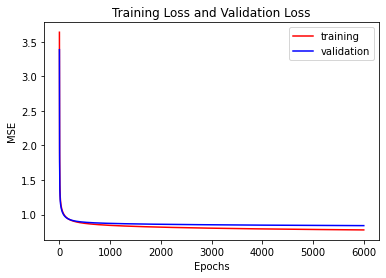

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(6000),l_hist,label='training',c='red')
plt.plot(range(6000),val_hist,label='validation',c='blue')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training Loss and Validation Loss")
plt.legend()
plt.show()  
plt.savefig('/content/drive/MyDrive/ECS271/NetFlix Assignment/train_val_loss.png')

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, len(loss_lamb))))
# with torch.no_grad():

#   for i in loss_lamb:
#     c = next(color)
#     plt.plot(range(500),loss_lamb[i] , c='red',label=f'Lambda: {i},training')
    
#     plt.plot(range(500),val_loss_lamb[i] , c='blue',label=f'Lambda: {i},validation')

#   plt.xlabel("Epochs")
#   plt.ylabel("MSE")
#   plt.title("Training Loss and Validation Loss")
#   plt.legend()
#   plt.show()  
#   plt.savefig('/content/drive/MyDrive/ECS271/NetFlix Assignment/train_val_loss.png')

In [ ]:

# color = iter(cm.rainbow(np.linspace(0, 1, len(val_loss_lamb))))
# for i in loss_lamb:
#    c = next(color)
#    plt.plot(range(300),val_loss_lamb[i] , c=c,label=f'Lambda: {i}')

# plt.xlabel("Epochs")
# plt.ylabel("MSE")
# plt.title("Validation Loss")
# plt.legend()
# plt.show() 
# plt.savefig('/content/drive/MyDrive/ECS271/NetFlix Assignment/val_loss.png') 

In [ ]:
# loss_lamb.keys()

In [ ]:
# with torch.no_grad():
#   pred=pred=bias_cus + bias_movie + M_curr + total_mean

Use Spectral Clustering to Predict the Cluster

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

In [ ]:
pred=np.loadtxt('/content/drive/MyDrive/ECS271/NetFlix Assignment/part1_pred_6000.out')

In [ ]:
# pred[pred<1]=1
# pred=np.around(pred)
mean_rating_by_user=np.mean(pred,axis=1,keepdims=True)
mean_rating_by_movie=np.mean(pred,axis=0,keepdims=True)
centered_pred=pred - mean_rating_by_user
# centered_pred=pred
sc=SpectralClustering(
        n_clusters=100,
        eigen_solver="arpack",
        affinity='nearest_neighbors'
    )
sc.fit(pred)
# sc = SpectralClustering(n_clusters=27).fit(pred)
print(sc)
labels = sc.labels_ 
np.savetxt('/content/drive/MyDrive/ECS271/NetFlix Assignment/clusters_6000.out',labels)

SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=100)


In [ ]:
# kmeans = KMeans(n_clusters=100, random_state=0).fit(pred)
# labels=kmeans.labels_

Created A Cluster Map that maps cluster-id to the users in the Cluster.

In [ ]:
from collections import defaultdict
cluster_map=defaultdict(list)
for i in range(len(labels)):
  cluster_map[labels[i]].append(i)

In [ ]:
total_mean=np.sum(pred)/(95318510)

In [ ]:

check=list(zip(users_ids_train,movies_ids_train)) 
check_y=Y_train_d

In [ ]:
from numpy import dot
from numpy.linalg import norm
import math



def predict_from_sc(user_id,mov_id):
  # handle cases if customer and movie not seen before
  if user_id not in cus_map and mov_id not in mov_map:
    return round(total_mean)

  #handle cases if customer not seen before
  if user_id in cus_map and mov_id not in mov_map:
    return round(mean_rating_by_user[cus_map[user_id]][0])

  #handle cases if movie not seen before
  if user_id not in cus_map and mov_id in mov_map:
    return round(mean_rating_by_movie[0][mov_map[mov_id]])  
  
  
  #user_id and mov_id not converted to indices in matrix yet.
  cus=cus_map[user_id]
  mov=mov_map[mov_id]
  
  
  c=labels[cus]
  mm=centered_pred[cus]
  #other users in the same cluster
  cus_in_cluster=cluster_map[c]
  wt=[]
  r=[]
  for i in cus_in_cluster:
    mi=centered_pred[i]
    w=np.dot(mm,mi)/(norm(mm)*norm(mi))
    wt.append(w)
    r.append(round(pred[i][mov])) 
  ss=0
  for i in range(len(wt)):
    ss+=wt[i]*r[i]
  # print('ss: ',ss)
  # print('sum wt: ',sum(wt))
  ans=ss/sum(wt)
  
  ans=round(ans)
  # ans=pred[cus][mov]
  # ans=round(ans)
  return ans   




In [ ]:
s=0
ans_y=[]
for i in range(len(check)):
  a,b=check[i]
  y=predict_from_sc(a,b)
  ans_y.append(y)
  s+=(check_y[i]-y)**2 
print(s/len(check))  

0.7514450867052023


In [ ]:

ans_y[70:90]

[2, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 2, 3, 4]

In [ ]:
check_y[70:90]

[1, 4, 5, 4, 4, 3, 2, 5, 5, 5, 5, 2, 2, 5, 5, 3, 1, 2, 4, 5]

In [ ]:
np.all(pred)

In [ ]:
test=pd.read_csv('/content/drive/MyDrive/ECS271/NetFlix Assignment/test.csv',header=None)

In [ ]:
test.columns=['movie-id','customer-id','rating','date']

In [ ]:
test.head()

,movie-id,customer-id,rating,date
0,11089,11765,?,2005-06-03
1,11279,5858,?,2005-05-07
2,12140,5202,?,2004-01-24
3,12191,18818,?,2005-03-27
4,12299,10021,?,2005-09-07


In [ ]:
c=test['customer-id'].to_list()
m=test['movie-id'].to_list()
r=test['rating'].to_list()

In [ ]:
from google.colab import output 
ans_1=[]
for i in range(len(c)):
  print(i)
  if i%10==0: 
    output.clear()
  aa=predict_from_sc(c[i],m[i])  
  ans_1.append(aa)


249991
249992
249993
249994
249995
249996
249997
249998
249999


In [ ]:
total_mean

3.6107077275916444

In [ ]:
ans_1=np.array(ans_1)

In [ ]:
ans_1.shape

(250000,)

In [ ]:
# np.save('/content/drive/MyDrive/ECS271/NetFlix Assignment/ans_1.npy',ans_1)

In [ ]:
# ans_1=np.load('/content/drive/MyDrive/ECS271/NetFlix Assignment/ans_1.npy')

In [ ]:
ans_1=np.clip(ans_1,1,5)

In [ ]:
np.max(ans_1)

5

In [ ]:
np.save('/content/drive/MyDrive/ECS271/NetFlix Assignment/ans_1.npy',ans_1)

In [ ]:
import numpy as np
ans_1=np.load('/content/drive/MyDrive/ECS271/NetFlix Assignment/ans_1.npy')

In [ ]:
ans_1.shape
ans_1[:20]

array([4, 3, 4, 4, 5, 3, 4, 3, 4, 4, 4, 5, 4, 5, 4, 4, 3, 4, 5, 4])

In [ ]:
np.savetxt('/content/drive/MyDrive/ECS271/NetFlix Assignment/ans_1.txt',ans_1)

In [ ]:
ans_2=np.load('/content/drive/MyDrive/ECS271/NetFlix Assignment/ans_1_p2.npy')

In [ ]:
ans_2[:20]

array([5, 3, 3, 4, 5, 3, 4, 3, 4, 3, 4, 4, 4, 5, 4, 4, 3, 5, 5, 4])

In [ ]:
np.savetxt('/content/drive/MyDrive/ECS271/NetFlix Assignment/ans_2.txt',ans_2)